# Classifier using LSTM layers

## 1. Importing Libraries

In [21]:
import torch

import numpy as np

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    categories = []
    files = os.listdir(folder)

    for file in files:
        fname = file[16:-7]
        if len(fname) > 0:
            categories.append(fname)

    if n is None:
        return categories

    return categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [3]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

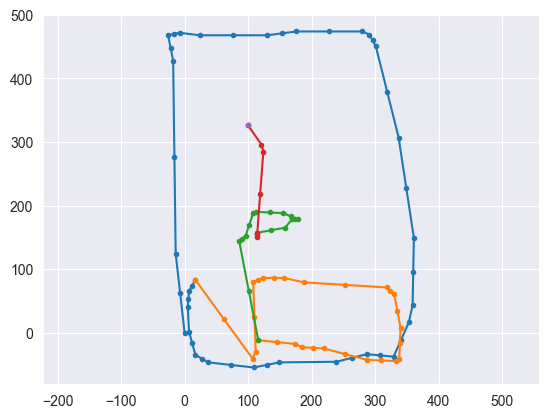

In [4]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    # Labels for the datasets
    camera_labels = np.ones(camera_drawings.shape[0])  # Label 1 for cameras
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2  # Label 2 for cellphones
    calculator_labels = np.zeros(calculator_drawings.shape[0])  # Label 0 for calculators

    # Combine the drawings from all categories
    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    # Split into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

# Usage example
X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [7]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    # Convert numpy arrays to TensorFlow tensors
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

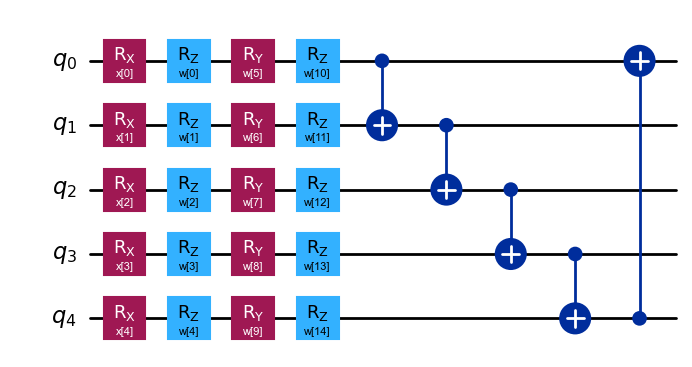

In [9]:
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)

    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        # self.fc3 = nn.Linear(64, n_qubits)
        # self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(64, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool3(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        # x = F.relu(self.fc3(x))
        # x = self.qnn(x)

        # Dense layer for classification
        x = F.softmax(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            # x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [14]:
checkpoint_filepath = 'models/lstm/best_model_weights_3classes.pth'

In [15]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 192/192 [00:04<00:00, 44.19it/s]


Epoch 1, Accuracy: 0.7565104166666666, Loss: 0.6891796770505607, Validation Accuracy: 0.8502604166666666, Validation Loss: 0.5911380052566528


100%|██████████| 192/192 [00:04<00:00, 43.94it/s]


Epoch 2, Accuracy: 0.869384765625, Loss: 0.5606699177684883, Validation Accuracy: 0.8974609375, Validation Loss: 0.4987611770629883


100%|██████████| 192/192 [00:04<00:00, 44.52it/s]


Epoch 3, Accuracy: 0.8965657552083334, Loss: 0.515770276542753, Validation Accuracy: 0.9098307291666666, Validation Loss: 0.4935739040374756


100%|██████████| 192/192 [00:04<00:00, 42.92it/s]


Epoch 4, Accuracy: 0.9054361979166666, Loss: 0.49844489828683436, Validation Accuracy: 0.9127604166666666, Validation Loss: 0.47206911444664


100%|██████████| 192/192 [00:04<00:00, 44.38it/s]


Epoch 5, Accuracy: 0.9185384114583334, Loss: 0.48211506094473106, Validation Accuracy: 0.9143880208333334, Validation Loss: 0.2693650424480438


100%|██████████| 192/192 [00:04<00:00, 44.03it/s]


Epoch 6, Accuracy: 0.9244791666666666, Loss: 0.21690142220662287, Validation Accuracy: 0.9186197916666666, Validation Loss: 0.20760852098464966


100%|██████████| 192/192 [00:04<00:00, 44.19it/s]


Epoch 7, Accuracy: 0.93505859375, Loss: 0.17057052864887132, Validation Accuracy: 0.9251302083333334, Validation Loss: 0.18201301991939545


100%|██████████| 192/192 [00:04<00:00, 44.40it/s]


Epoch 8, Accuracy: 0.9423828125, Loss: 0.1567903472847926, Validation Accuracy: 0.9326171875, Validation Loss: 0.1685320883989334


100%|██████████| 192/192 [00:04<00:00, 43.23it/s]


Epoch 9, Accuracy: 0.9480794270833334, Loss: 0.14004355070452826, Validation Accuracy: 0.9270833333333334, Validation Loss: 0.18489493429660797


100%|██████████| 192/192 [00:04<00:00, 44.53it/s]


Epoch 10, Accuracy: 0.9519856770833334, Loss: 0.13168986300782612, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.18049873411655426


100%|██████████| 192/192 [00:04<00:00, 44.07it/s]


Epoch 11, Accuracy: 0.9569498697916666, Loss: 0.11418366878448676, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.16566786170005798


100%|██████████| 192/192 [00:04<00:00, 44.72it/s]


Epoch 12, Accuracy: 0.9599609375, Loss: 0.10641880700616942, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.18358981609344482


100%|██████████| 192/192 [00:04<00:00, 44.31it/s]


Epoch 13, Accuracy: 0.9609375, Loss: 0.10441082294952746, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.16446220874786377


100%|██████████| 192/192 [00:04<00:00, 43.37it/s]


Epoch 14, Accuracy: 0.96533203125, Loss: 0.09260274957341608, Validation Accuracy: 0.9339192708333334, Validation Loss: 0.17478333413600922


100%|██████████| 192/192 [00:04<00:00, 44.11it/s]


Epoch 15, Accuracy: 0.96533203125, Loss: 0.09506457161720998, Validation Accuracy: 0.931640625, Validation Loss: 0.1919918656349182


100%|██████████| 192/192 [00:04<00:00, 43.81it/s]


Epoch 16, Accuracy: 0.974609375, Loss: 0.06830480498077425, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.19183224439620972


100%|██████████| 192/192 [00:04<00:00, 43.84it/s]


Epoch 17, Accuracy: 0.97412109375, Loss: 0.06948101562253821, Validation Accuracy: 0.9436848958333334, Validation Loss: 0.1817319244146347


100%|██████████| 192/192 [00:04<00:00, 44.28it/s]


Epoch 18, Accuracy: 0.9737141927083334, Loss: 0.0704027090469026, Validation Accuracy: 0.9417317708333334, Validation Loss: 0.17713524401187897


100%|██████████| 192/192 [00:04<00:00, 43.44it/s]


Epoch 19, Accuracy: 0.9773763020833334, Loss: 0.056836024446965894, Validation Accuracy: 0.9365234375, Validation Loss: 0.21241028606891632


100%|██████████| 192/192 [00:04<00:00, 45.08it/s]


Epoch 20, Accuracy: 0.978271484375, Loss: 0.05877876221590365, Validation Accuracy: 0.9358723958333334, Validation Loss: 0.20078641176223755


100%|██████████| 192/192 [00:04<00:00, 41.78it/s]


Epoch 21, Accuracy: 0.9830729166666666, Loss: 0.04568379053125682, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.26433366537094116


100%|██████████| 192/192 [00:04<00:00, 44.08it/s]


Epoch 22, Accuracy: 0.98095703125, Loss: 0.055355757537957594, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.27785536646842957


100%|██████████| 192/192 [00:04<00:00, 43.92it/s]


Epoch 23, Accuracy: 0.984619140625, Loss: 0.04321345822851678, Validation Accuracy: 0.9420572916666666, Validation Loss: 0.23367172479629517


100%|██████████| 192/192 [00:04<00:00, 44.04it/s]


Epoch 24, Accuracy: 0.9877115885416666, Loss: 0.03464329063262994, Validation Accuracy: 0.9443359375, Validation Loss: 0.23580099642276764


100%|██████████| 192/192 [00:04<00:00, 43.88it/s]


Epoch 25, Accuracy: 0.9853515625, Loss: 0.043064884232686985, Validation Accuracy: 0.9397786458333334, Validation Loss: 0.22249634563922882


100%|██████████| 192/192 [00:04<00:00, 44.44it/s]


Epoch 26, Accuracy: 0.9901529947916666, Loss: 0.02679849928654221, Validation Accuracy: 0.921875, Validation Loss: 0.28364285826683044


100%|██████████| 192/192 [00:04<00:00, 43.91it/s]


Epoch 27, Accuracy: 0.9890950520833334, Loss: 0.030971158100328466, Validation Accuracy: 0.9339192708333334, Validation Loss: 0.22844117879867554


100%|██████████| 192/192 [00:04<00:00, 43.26it/s]


Epoch 28, Accuracy: 0.9901529947916666, Loss: 0.028170135987541773, Validation Accuracy: 0.9322916666666666, Validation Loss: 0.26687389612197876


100%|██████████| 192/192 [00:04<00:00, 44.30it/s]


Epoch 29, Accuracy: 0.990478515625, Loss: 0.02794978919064306, Validation Accuracy: 0.9391276041666666, Validation Loss: 0.25710657238960266


100%|██████████| 192/192 [00:04<00:00, 44.02it/s]


Epoch 30, Accuracy: 0.9903157552083334, Loss: 0.026114447517860146, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.26178619265556335


100%|██████████| 192/192 [00:04<00:00, 43.20it/s]


Epoch 31, Accuracy: 0.994140625, Loss: 0.01925822753385849, Validation Accuracy: 0.9401041666666666, Validation Loss: 0.28939783573150635


100%|██████████| 192/192 [00:04<00:00, 43.92it/s]


Epoch 32, Accuracy: 0.9913736979166666, Loss: 0.023669473828249465, Validation Accuracy: 0.9378255208333334, Validation Loss: 0.25030264258384705


100%|██████████| 192/192 [00:04<00:00, 44.23it/s]


Epoch 33, Accuracy: 0.9923502604166666, Loss: 0.023026540185583144, Validation Accuracy: 0.9326171875, Validation Loss: 0.27325740456581116


100%|██████████| 192/192 [00:04<00:00, 44.00it/s]


Epoch 34, Accuracy: 0.994140625, Loss: 0.019964735121751193, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2956206798553467


100%|██████████| 192/192 [00:04<00:00, 44.05it/s]


Epoch 35, Accuracy: 0.9925130208333334, Loss: 0.021246762785608553, Validation Accuracy: 0.935546875, Validation Loss: 0.25249508023262024


100%|██████████| 192/192 [00:04<00:00, 43.12it/s]


Epoch 36, Accuracy: 0.9951171875, Loss: 0.014303235016389712, Validation Accuracy: 0.9391276041666666, Validation Loss: 0.3560574948787689


100%|██████████| 192/192 [00:04<00:00, 43.23it/s]


Epoch 37, Accuracy: 0.9911295572916666, Loss: 0.02675006856490351, Validation Accuracy: 0.9404296875, Validation Loss: 0.2974713146686554


100%|██████████| 192/192 [00:04<00:00, 44.51it/s]


Epoch 38, Accuracy: 0.993408203125, Loss: 0.018710201081376, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.33942294120788574


100%|██████████| 192/192 [00:04<00:00, 43.95it/s]


Epoch 39, Accuracy: 0.9931640625, Loss: 0.019712164376414876, Validation Accuracy: 0.931640625, Validation Loss: 0.2897305190563202


100%|██████████| 192/192 [00:04<00:00, 45.49it/s]


Epoch 40, Accuracy: 0.9947916666666666, Loss: 0.015401112802540714, Validation Accuracy: 0.9436848958333334, Validation Loss: 0.29768940806388855


100%|██████████| 192/192 [00:04<00:00, 44.99it/s]


Epoch 41, Accuracy: 0.9954427083333334, Loss: 0.013082673553147591, Validation Accuracy: 0.9251302083333334, Validation Loss: 0.3713425099849701


100%|██████████| 192/192 [00:04<00:00, 42.70it/s]


Epoch 42, Accuracy: 0.9955240885416666, Loss: 0.013901655245717848, Validation Accuracy: 0.9361979166666666, Validation Loss: 0.3372652530670166


100%|██████████| 192/192 [00:04<00:00, 44.11it/s]


Epoch 43, Accuracy: 0.9939778645833334, Loss: 0.018359124575416292, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.31016314029693604


100%|██████████| 192/192 [00:04<00:00, 44.22it/s]


Epoch 44, Accuracy: 0.9949544270833334, Loss: 0.01425543044092592, Validation Accuracy: 0.9410807291666666, Validation Loss: 0.2989727258682251


100%|██████████| 192/192 [00:04<00:00, 43.80it/s]


Epoch 45, Accuracy: 0.9954427083333334, Loss: 0.012488316754740936, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.3084920346736908


100%|██████████| 192/192 [00:04<00:00, 44.35it/s]


Epoch 46, Accuracy: 0.9931640625, Loss: 0.02013457953262332, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.33632853627204895


100%|██████████| 192/192 [00:04<00:00, 43.88it/s]


Epoch 47, Accuracy: 0.99609375, Loss: 0.010630137585962984, Validation Accuracy: 0.9319661458333334, Validation Loss: 0.35031381249427795


100%|██████████| 192/192 [00:04<00:00, 42.58it/s]


Epoch 48, Accuracy: 0.9955240885416666, Loss: 0.014586766166909607, Validation Accuracy: 0.939453125, Validation Loss: 0.3224916160106659


100%|██████████| 192/192 [00:04<00:00, 42.15it/s]


Epoch 49, Accuracy: 0.9937337239583334, Loss: 0.018758069101295405, Validation Accuracy: 0.9339192708333334, Validation Loss: 0.2765663266181946


100%|██████████| 192/192 [00:04<00:00, 42.03it/s]


Epoch 50, Accuracy: 0.9969889322916666, Loss: 0.008783636606589576, Validation Accuracy: 0.9375, Validation Loss: 0.35218432545661926


100%|██████████| 192/192 [00:04<00:00, 43.22it/s]


Epoch 51, Accuracy: 0.99072265625, Loss: 0.02743404428717137, Validation Accuracy: 0.9375, Validation Loss: 0.2960710823535919


100%|██████████| 192/192 [00:04<00:00, 43.96it/s]


Epoch 52, Accuracy: 0.9960123697916666, Loss: 0.013765650861311466, Validation Accuracy: 0.9329427083333334, Validation Loss: 0.3343370854854584


100%|██████████| 192/192 [00:04<00:00, 44.63it/s]


Epoch 53, Accuracy: 0.9957682291666666, Loss: 0.011482999074919084, Validation Accuracy: 0.9319661458333334, Validation Loss: 0.3400540351867676


100%|██████████| 192/192 [00:04<00:00, 43.52it/s]


Epoch 54, Accuracy: 0.9952799479166666, Loss: 0.013683278222250314, Validation Accuracy: 0.9391276041666666, Validation Loss: 0.29396316409111023


100%|██████████| 192/192 [00:04<00:00, 44.45it/s]


Epoch 55, Accuracy: 0.995361328125, Loss: 0.015979054185360535, Validation Accuracy: 0.9381510416666666, Validation Loss: 0.29066744446754456


100%|██████████| 192/192 [00:04<00:00, 44.78it/s]


Epoch 56, Accuracy: 0.9974772135416666, Loss: 0.009819358919912702, Validation Accuracy: 0.93359375, Validation Loss: 0.31749823689460754


100%|██████████| 192/192 [00:04<00:00, 44.57it/s]


Epoch 57, Accuracy: 0.9955240885416666, Loss: 0.012711586039661901, Validation Accuracy: 0.931640625, Validation Loss: 0.34990906715393066


100%|██████████| 192/192 [00:04<00:00, 44.14it/s]


Epoch 58, Accuracy: 0.9951985677083334, Loss: 0.014406398316301269, Validation Accuracy: 0.9378255208333334, Validation Loss: 0.28474268317222595


100%|██████████| 192/192 [00:04<00:00, 44.42it/s]


Epoch 59, Accuracy: 0.9984537760416666, Loss: 0.0043712484131693445, Validation Accuracy: 0.9345703125, Validation Loss: 0.3642055094242096


100%|██████████| 192/192 [00:04<00:00, 43.77it/s]


Epoch 60, Accuracy: 0.9965006510416666, Loss: 0.01033494060201671, Validation Accuracy: 0.9303385416666666, Validation Loss: 0.3430509567260742


100%|██████████| 192/192 [00:04<00:00, 42.88it/s]


Epoch 61, Accuracy: 0.9961751302083334, Loss: 0.01106723610013205, Validation Accuracy: 0.9332682291666666, Validation Loss: 0.3533289134502411


100%|██████████| 192/192 [00:04<00:00, 44.30it/s]


Epoch 62, Accuracy: 0.9952799479166666, Loss: 0.01373660343233496, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.37152114510536194


100%|██████████| 192/192 [00:04<00:00, 43.63it/s]


Epoch 63, Accuracy: 0.9954427083333334, Loss: 0.013080014866886813, Validation Accuracy: 0.9326171875, Validation Loss: 0.3531993627548218


100%|██████████| 192/192 [00:04<00:00, 44.92it/s]


Epoch 64, Accuracy: 0.991943359375, Loss: 0.02365919246237051, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.2948475778102875


100%|██████████| 192/192 [00:04<00:00, 44.95it/s]


Epoch 65, Accuracy: 0.9960123697916666, Loss: 0.013129334579616625, Validation Accuracy: 0.935546875, Validation Loss: 0.3052467405796051


100%|██████████| 192/192 [00:04<00:00, 44.19it/s]


Epoch 66, Accuracy: 0.998779296875, Loss: 0.0035253643060713102, Validation Accuracy: 0.9436848958333334, Validation Loss: 0.4018280804157257


100%|██████████| 192/192 [00:04<00:00, 44.22it/s]


Epoch 67, Accuracy: 0.9966634114583334, Loss: 0.009570983180509529, Validation Accuracy: 0.9345703125, Validation Loss: 0.36756932735443115


100%|██████████| 192/192 [00:04<00:00, 44.08it/s]


Epoch 68, Accuracy: 0.996826171875, Loss: 0.009419587545191158, Validation Accuracy: 0.9348958333333334, Validation Loss: 0.3256722688674927


100%|██████████| 192/192 [00:04<00:00, 43.72it/s]


Epoch 69, Accuracy: 0.99658203125, Loss: 0.008795740577530372, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.2992827296257019


100%|██████████| 192/192 [00:04<00:00, 43.72it/s]


Epoch 70, Accuracy: 0.9976399739583334, Loss: 0.006867596313365236, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.37110698223114014


100%|██████████| 192/192 [00:04<00:00, 43.93it/s]


Epoch 71, Accuracy: 0.9961751302083334, Loss: 0.01275692163634782, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.2960255444049835


100%|██████████| 192/192 [00:04<00:00, 41.86it/s]


Epoch 72, Accuracy: 0.9962565104166666, Loss: 0.01221282634524338, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.3286832571029663


100%|██████████| 192/192 [00:04<00:00, 43.05it/s]


Epoch 73, Accuracy: 0.993896484375, Loss: 0.01594294526948185, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.324100524187088


100%|██████████| 192/192 [00:04<00:00, 45.93it/s]


Epoch 74, Accuracy: 0.9974772135416666, Loss: 0.011022916350678239, Validation Accuracy: 0.9261067708333334, Validation Loss: 0.3332017958164215


100%|██████████| 192/192 [00:04<00:00, 43.68it/s]


Epoch 75, Accuracy: 0.9959309895833334, Loss: 0.011588901759258382, Validation Accuracy: 0.9290364583333334, Validation Loss: 0.36355146765708923


100%|██████████| 192/192 [00:04<00:00, 44.15it/s]


Epoch 76, Accuracy: 0.9977213541666666, Loss: 0.006725968061383962, Validation Accuracy: 0.9313151041666666, Validation Loss: 0.3325829803943634


100%|██████████| 192/192 [00:04<00:00, 44.37it/s]


Epoch 77, Accuracy: 0.9979654947916666, Loss: 0.005958407977099493, Validation Accuracy: 0.9303385416666666, Validation Loss: 0.3726682960987091


100%|██████████| 192/192 [00:04<00:00, 43.58it/s]


Epoch 78, Accuracy: 0.9986979166666666, Loss: 0.004224744187505773, Validation Accuracy: 0.9309895833333334, Validation Loss: 0.4432055652141571


100%|██████████| 192/192 [00:04<00:00, 44.22it/s]


Epoch 79, Accuracy: 0.9966634114583334, Loss: 0.013745121640189003, Validation Accuracy: 0.94140625, Validation Loss: 0.30242517590522766


100%|██████████| 192/192 [00:04<00:00, 44.20it/s]


Epoch 80, Accuracy: 0.9983723958333334, Loss: 0.0052988822560943545, Validation Accuracy: 0.9326171875, Validation Loss: 0.375348836183548


100%|██████████| 192/192 [00:04<00:00, 44.31it/s]


Epoch 81, Accuracy: 0.9970703125, Loss: 0.009821033921994626, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.27466467022895813


100%|██████████| 192/192 [00:04<00:00, 44.08it/s]


Epoch 82, Accuracy: 0.99462890625, Loss: 0.016714653559877963, Validation Accuracy: 0.935546875, Validation Loss: 0.3322741985321045


100%|██████████| 192/192 [00:04<00:00, 43.85it/s]


Epoch 83, Accuracy: 0.9966634114583334, Loss: 0.010075619306273135, Validation Accuracy: 0.93359375, Validation Loss: 0.38609716296195984


100%|██████████| 192/192 [00:04<00:00, 44.16it/s]


Epoch 84, Accuracy: 0.9967447916666666, Loss: 0.009632549021944214, Validation Accuracy: 0.9342447916666666, Validation Loss: 0.3095090687274933


100%|██████████| 192/192 [00:04<00:00, 44.35it/s]


Epoch 85, Accuracy: 0.9969075520833334, Loss: 0.010255622513530701, Validation Accuracy: 0.9375, Validation Loss: 0.33868908882141113


100%|██████████| 192/192 [00:04<00:00, 44.41it/s]


Epoch 86, Accuracy: 0.9957682291666666, Loss: 0.01291377853154548, Validation Accuracy: 0.9404296875, Validation Loss: 0.28757762908935547


100%|██████████| 192/192 [00:04<00:00, 43.95it/s]


Epoch 87, Accuracy: 0.9989420572916666, Loss: 0.0031386168279349627, Validation Accuracy: 0.9407552083333334, Validation Loss: 0.3972015082836151


100%|██████████| 192/192 [00:04<00:00, 44.75it/s]


Epoch 88, Accuracy: 0.9959309895833334, Loss: 0.013286061840645402, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.33799293637275696


100%|██████████| 192/192 [00:04<00:00, 44.07it/s]


Epoch 89, Accuracy: 0.9977213541666666, Loss: 0.008358730128634306, Validation Accuracy: 0.93359375, Validation Loss: 0.3458639681339264


100%|██████████| 192/192 [00:04<00:00, 44.24it/s]


Epoch 90, Accuracy: 0.9991048177083334, Loss: 0.002154250574198121, Validation Accuracy: 0.943359375, Validation Loss: 0.39432188868522644


100%|██████████| 192/192 [00:04<00:00, 44.05it/s]


Epoch 91, Accuracy: 0.9952799479166666, Loss: 0.012655444445210643, Validation Accuracy: 0.9388020833333334, Validation Loss: 0.31281939148902893


100%|██████████| 192/192 [00:04<00:00, 44.62it/s]


Epoch 92, Accuracy: 0.997802734375, Loss: 0.007357308941853565, Validation Accuracy: 0.9235026041666666, Validation Loss: 0.46332836151123047


100%|██████████| 192/192 [00:04<00:00, 44.37it/s]


Epoch 93, Accuracy: 0.9979654947916666, Loss: 0.006447589273534504, Validation Accuracy: 0.931640625, Validation Loss: 0.38933971524238586


100%|██████████| 192/192 [00:04<00:00, 44.46it/s]


Epoch 94, Accuracy: 0.9971516927083334, Loss: 0.009481696723203944, Validation Accuracy: 0.9300130208333334, Validation Loss: 0.36024919152259827


100%|██████████| 192/192 [00:04<00:00, 44.45it/s]


Epoch 95, Accuracy: 0.9966634114583334, Loss: 0.011050254634009585, Validation Accuracy: 0.9368489583333334, Validation Loss: 0.30393078923225403


100%|██████████| 192/192 [00:04<00:00, 44.32it/s]


Epoch 96, Accuracy: 0.99853515625, Loss: 0.00525774319975388, Validation Accuracy: 0.9326171875, Validation Loss: 0.36774978041648865


100%|██████████| 192/192 [00:04<00:00, 43.88it/s]


Epoch 97, Accuracy: 0.9986979166666666, Loss: 0.004597667816852891, Validation Accuracy: 0.9371744791666666, Validation Loss: 0.36518144607543945


100%|██████████| 192/192 [00:04<00:00, 44.54it/s]


Epoch 98, Accuracy: 0.997314453125, Loss: 0.009475087446612443, Validation Accuracy: 0.9270833333333334, Validation Loss: 0.2940649092197418


100%|██████████| 192/192 [00:04<00:00, 44.98it/s]


Epoch 99, Accuracy: 0.9981282552083334, Loss: 0.006360173795286528, Validation Accuracy: 0.9384765625, Validation Loss: 0.3763371706008911


100%|██████████| 192/192 [00:04<00:00, 43.48it/s]


Epoch 100, Accuracy: 0.9981282552083334, Loss: 0.006423734251673825, Validation Accuracy: 0.9352213541666666, Validation Loss: 0.3476611375808716


## 5. Model Evaluation

### 5.1. Plotting the Training and Validation Loss

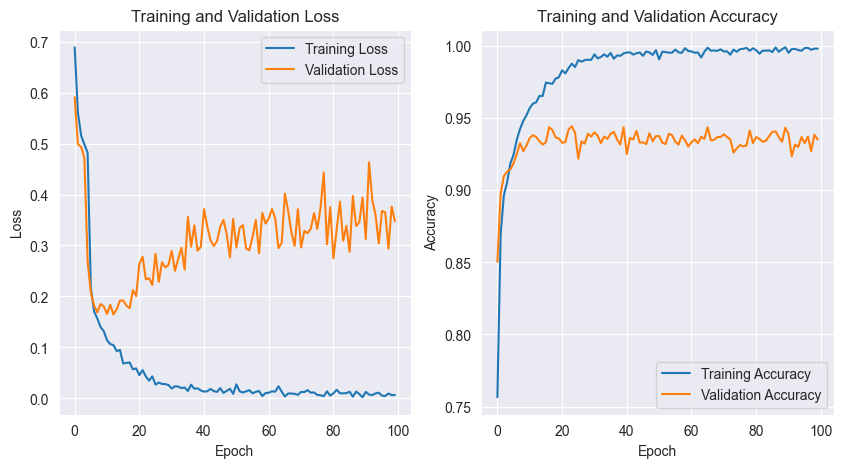

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [30]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [31]:
outputs = model.predict(X_test)

In [33]:
y_pred = np.argmax(outputs, axis=1)
y_pred

array([2, 2, 2, ..., 0, 0, 2], dtype=int64)

In [38]:
INDEX = 6

out = model.predict([X_test[:2500][INDEX]])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: calculator
